## Local embeddings modeling notebook

In [5]:
%load_ext autoreload
%autoreload 2

import geopandas as gpd
import duckdb
import os
from tqdm import tqdm


from datetime import datetime
import json
import os

import geopandas as gpd
import ipyleaflet as ipyl
from IPython.display import display
import ipywidgets as ipyw
import joblib
import numpy as np
import pandas as pd

import sys
import pathlib
sys.path.insert(0, 'src')

from ui import GeoLabeler


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
with open('config/ui_config.json', 'r') as f:
    config = json.load(f)

local_dir = config['local_dir']
duckdb_path = '/Users/christopherren/geovibes/notebooks/bali.db'
embeddings_con = duckdb.connect(duckdb_path)
valid_tile_dir = os.path.join(local_dir, 'tiles')

mgrs_ids = config['mgrs_ids']
start_date = config['start_date']
end_date = config['end_date']
imagery = config['imagery']


In [7]:
from ui import GeoLabeler


BOUNDARY_PATH = os.path.join(pathlib.Path().resolve(), "places/bali.geojson")
BOUNDARY = gpd.read_file(BOUNDARY_PATH)
maptiler_attribution = '<a href="https://www.maptiler.com/copyright/" target="_blank">&copy; MapTiler</a> <a href="https://www.openstreetmap.org/copyright" target="_blank">&copy; OpenStreetMap contributors</a>'

labeler = GeoLabeler(
                    geojson_path=BOUNDARY_PATH,
                    mgrs_ids=mgrs_ids,
                    start_date=start_date,
                    end_date=end_date,
                    imagery=imagery,
                    duckdb_connection=embeddings_con,
                    attribution=maptiler_attribution)


label = ipyw.Label(); display(label)  

def handle_mouse_move(**kwargs):
    lat, lon = kwargs.get('coordinates')
    label_type = "Erase" if labeler.select_val == -100 else "Negative" if labeler.select_val == 0 else "Positive"
    label.value = f'Lat/lon: {lat:.4f}, {lon:.4f}. Mode: {"lasso" if labeler.lasso_mode else "single"}. Labeling: {label_type}'

labeler.map.on_interaction(handle_mouse_move)

Initializing GeoLabeler...
Adding controls...


Label(value='')

Updated query vector from 1 positive and 0 negative labels


## Search
First search make take a while as the table is loaded into memory

In [ ]:
# Do ANN search using DuckDB HSNW
n_nbors = 1000000

# Convert query vector to the format needed for DuckDB
query_vec = labeler.query_vector.tolist()

sql = """
WITH query(vec) AS (SELECT CAST(? AS FLOAT[384]))
SELECT  g.id,
        ST_AsGeoJSON(g.geometry) AS geometry,
        array_cosine_distance(g.embedding, q.vec) AS distance
FROM    geo_embeddings AS g, query AS q
ORDER BY distance
LIMIT ?;
"""

search_results = labeler.duckdb_connection.execute(sql, [query_vec, n_nbors]).df()

# Filter out any IDs that are already in positive labels
search_results_filtered = search_results[~search_results['id'].isin(labeler.pos_ids)]

# Create proper GeoJSON for map display
detections_geojson = {
    "type": "FeatureCollection",
    "features": []
}

for _, row in search_results_filtered.iterrows():
    detections_geojson["features"].append({
        "type": "Feature",
        "geometry": json.loads(row['geometry']),
        "properties": {"id": row['id'], "distance": row['distance']}
    })

# Update the map - this should now work
labeler.update_layer(labeler.points, detections_geojson)

# Store detection IDs for lasso selection
labeler.detection_ids = search_results_filtered['id'].tolist()

print(f"Displaying {len(detections_geojson['features'])} search results on map")

In [18]:
# Do ANN search using DuckDB HSNW
import shapely.wkb, shapely.wkt
n_nbors = 100

# Convert query vector to the format needed for DuckDB
query_vec = labeler.query_vector.tolist()

sql = """
WITH query(vec) AS (SELECT CAST(? AS FLOAT[384]))
SELECT  g.id,
        ST_AsText(g.geometry) AS wkt,
        array_distance(g.embedding, q.vec) AS distance
FROM    geo_embeddings AS g, query AS q
ORDER BY distance
LIMIT ?;
"""

search_results = labeler.duckdb_connection.execute(sql, [query_vec, n_nbors]).df()
search_results['geometry'] = search_results['wkt'].apply(shapely.wkt.loads)
search_results = gpd.GeoDataFrame(search_results, geometry='geometry')

# Update the GeoLabeler and map
labeler.detection_gdf = search_results[['geometry']]
labeler.update_layer(
    labeler.points, json.loads(search_results.geometry.to_json()))

<Axes: >

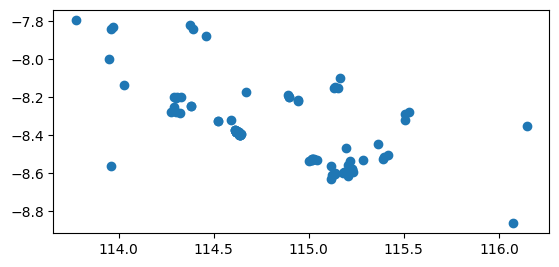

In [20]:
labeler.detection_gdf.plot()

In [14]:

# Update the GeoLabeler and map
labeler.detection_gdf = search_results[['wkt']]
labeler.update_layer(
    labeler.points, json.loads(search_results.wkt.to_json()))

In [9]:
# Get points
pos = labeler.gdf.loc[labeler.pos_ids]
neg = labeler.gdf.loc[labeler.neg_ids]

# Create query vector
pos_embeddings = labeler.get_embeddings_by_tile_ids(pos['tile_id'].values)
if len(neg) > 0:
    neg_embeddings = labeler.get_embeddings_by_tile_ids(neg['tile_id'].values)
    neg_vec = neg_embeddings.drop(columns=['tile_id', 'row_number']).mean(axis=0).values
else:
    neg_vec = np.zeros(pos_embeddings.shape[1] - 2)
pos_vec = pos_embeddings.drop(columns=['tile_id', 'row_number']).mean(axis=0).values

# Default query vector math, feel free to experiment with alternatives
query_vector = 2 * pos_vec - neg_vec


## Old annoy code

In [5]:
# Do ANN search

n_nbors = 13000

nbors = labeler.annoy_index.get_nns_by_vector(query_vector, n_nbors, include_distances=True)

# Filter out any IDs that are already in positive labels
nbors_filtered = [n for n in nbors[0] if n not in labeler.pos_ids]

detections = labeler.gdf.loc[nbors_filtered]

# Update the GeoLabeler and map
labeler.detection_gdf = detections[['geometry']]
labeler.update_layer(
    labeler.points, json.loads(detections.geometry.to_json()))

## Export

In [12]:
# Export the positives and negatives
pos_export = labeler.gdf.loc[labeler.pos_ids]
neg_export = labeler.gdf.loc[labeler.neg_ids]

# Add label columns
pos_export['label'] = 1
neg_export['label'] = 0




In [ ]:
EXPORT_TYPE = "POSITIVE" # "FULL" or "POSITIVE"

if EXPORT_TYPE == "FULL":
# Combine into one gdf
    export_gdf = pd.concat([pos_export, neg_export], ignore_index=True)

elif EXPORT_TYPE == "POSITIVE":
    # Combine into one gdf
    export_gdf = pos_export

# Export to a parquet file
export_path = os.path.join(local_dir, f'{EXPORT_TYPE}_labels.parquet'.lower())
export_gdf.to_parquet(export_path, index=False)

## Classifer 
After export, please return to the README to follow the next steps through model training, inference, and post-processing.

# Load

## Option 1: Load a previously saved set of labels

In [5]:
# Helper function

def display_labels_on_labeler(labeler, labels_gdf):
    """
    Display positive and negative labels on the GeoLabeler instance.

    Args:
        labeler (GeoLabeler): The GeoLabeler instance.
        labels_gdf (GeoDataFrame): The GeoDataFrame containing labels.
    """
    if labels_gdf is not None:
        pos_tile_ids = labels_gdf.loc[labels_gdf['label'] == 1, 'tile_id'].tolist()
        neg_tile_ids = labels_gdf.loc[labels_gdf['label'] == 0, 'tile_id'].tolist()

        # Get index values from labeler's GeoDataFrame where tile_id is in pos_tile_ids and neg_tile_ids
        pos_indices = labeler.gdf[labeler.gdf['tile_id'].isin(pos_tile_ids)].index.tolist()
        neg_indices = labeler.gdf[labeler.gdf['tile_id'].isin(neg_tile_ids)].index.tolist()

        # Update labeler with positive and negative IDs
        labeler.pos_ids = pos_indices
        labeler.neg_ids = neg_indices

        # Update the map layers to reflect loaded labels
        labeler.update_layers()
        print("Labels displayed on labeler.")
    else:
        print("No labels to display.")



In [6]:
# Load previously exported labels

labels_file_path = os.path.join(local_dir, 'full_labels.parquet')
if os.path.exists(labels_file_path):
    labels_gdf = gpd.read_parquet(labels_file_path)
    print(len(labels_gdf), "labels loaded")
    display_labels_on_labeler(labeler, labels_gdf)

280 labels loaded
Labels displayed on labeler.


## Option 2: Load post-processed detections after model training and inference

In [7]:
# Add polygons from postprocess_detections.py

dissolved = gpd.read_parquet("/Users/ben/EarthGenome/data/costa_rica_pineapple/output/tile_classifier_predictions_1_costa_rica_posw1.0_prob_0.98_postprocess.parquet")

labeler.dissolve_layer = ipyl.GeoJSON(
    data=json.loads(dissolved.geometry.to_json()),
    style={'color': 'blue', 'opacity': 0.5, 'weight': 2, 'fillOpacity': 0.1},
    name='Dissolved Polygons'
)

labeler.map.add_layer(labeler.dissolve_layer)